[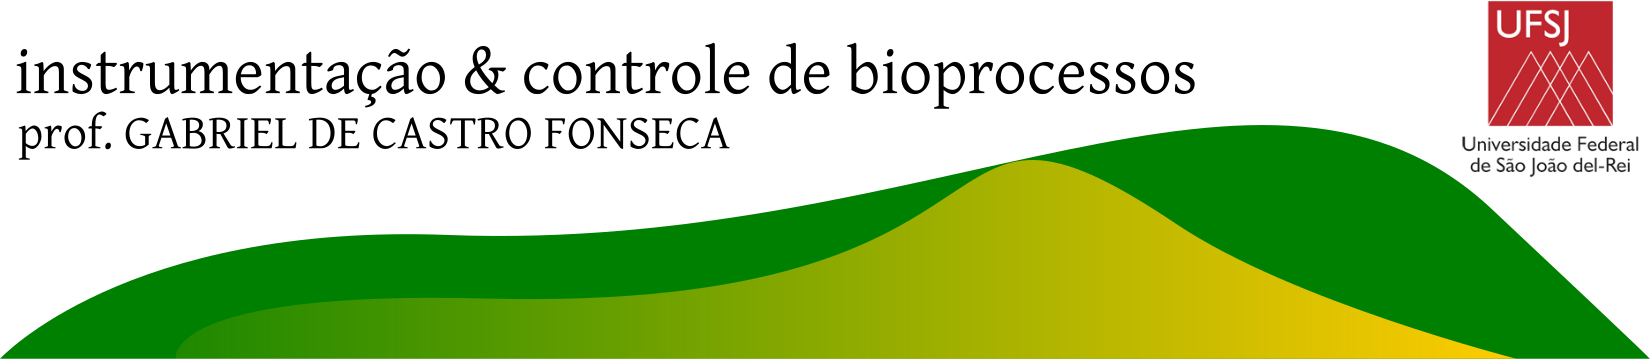](Aulas-Sumário.ipynb)

# Controle por Realimentação II

*Prof. Gabriel de Castro Fonseca (DQBIO/UFSJ)*<br>
*Instrumentação e Controle de Bioprocessos*

Este documento é publicado sob os termos da licença [GNU General Public Licence 3.0](https://www.gnu.org/licenses/gpl-3.0.en.html).

## Controle Proporcional-Integral

Na [aula passada](pid1.ipynb) estudamos o controle em realimentação e apresentamos duas estratégias de controle diferentes: o controle liga-desliga e o proporcional. O controle proporcional pertence à família dos controladores PID, que como veremos nesta aula ainda podem conter os termos integral e derivativo.

Voltando ao problema do refrigerador proposto na aula passada, cujo comportamento em malha aberta podia ser representado como

\begin{gather*}
    8 \frac{dy}{dt} + y = d(t) + 0,2 m(t) \\
    y(t) = \underbrace{\frac{1}{8s+1}}_{H(s)} d(t) + \underbrace{\frac{0,2}{8s+1}}_{G(s)} m(t)
\end{gather*}

O comportamento em malha fechada de realimentação seria dado por

\begin{equation}
y(t) = \underbrace{\frac{H(s)}{1 + C(s)F(s)G(s)T(s)}}_{R(s)} d(t) + \underbrace{\frac{C(s)F(s)G(s)}{1 + C(s)F(s)G(s)T(s)}}_{S(s)} y^*(t)
\end{equation}

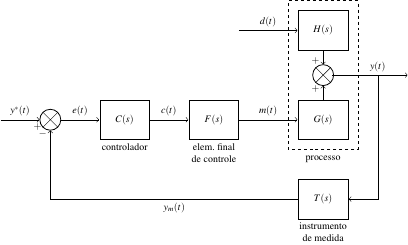

Consideraremos $T(s) = 1$ e $F(s) = K_f$. Em relação ao problema resolvido na aula passada, só o que muda é a função de transferência do controlador, que no caso do PI é dada por

\begin{equation}
    c(t) = K_c \left( e(t) + \frac{1}{\tau_I}\int_0^t e(t) dt \right) \\
    C(s) = \frac{c(t)}{e(t)} = K_c \left( 1 + \frac{1}{\tau_Is}\right)
\end{equation}

A resposta de um sistema capacitivo de primeira ordem sob controle PI em malha fechada seria dada por

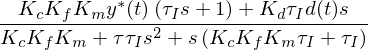

In [1]:
import sympy as sym
sym.init_printing()

d, ysp, s = sym.symbols('d(t), y^{*}(t), s')
τ, τi, Km, Kd, Kc, Kf = sym.symbols(r'\tau, \tau_I, K_m, K_d, K_c, K_f')
C = Kc * (τi*s + 1)/τi/s
F = Kf
G = Km/(τ*s+1)
H = Kd/(τ*s+1)

y = H/(1+C*F*G)*d + C*F*G/(1+C*F*G)*ysp
n,d = sym.fraction(y.simplify())
z = n/d.expand().collect(s)
z

A resposta em malha fechada pode ser escrita como

\begin{gather*}
    y(t) = \frac{ \frac{K_d}{K_cK_fK_m} \tau_I s }{\frac{\tau\tau_I}{K_cK_fK_m} s^2 + \tau_I s( 1 + \frac{1}{K_cK_fK_m}) + 1 } d(t) + \frac{\tau_Is + 1}{\frac{\tau\tau_I}{K_cK_fK_m} s^2 + \tau_I s( 1 + \frac{1}{K_cK_fK_m}) + 1 } y^*(t) \\
    y(t) = \frac{\sigma^\prime s}{\tau^{\prime 2} s^2 + 2\zeta^\prime \tau^\prime s + 1} d(t) + \frac{\tau_I s + 1}{\tau^{\prime 2} s^2 + 2\zeta^\prime \tau^\prime s + 1} y^*(t)
\end{gather*}

Ou seja, o controle PI faz com que o sistema que era de primeira ordem em malha aberta tenha uma resposta de segunda ordem [com avanço](especiais.ipynb) em malha fechada.

Observe que o avanço puro no termo regulador faz com que o sistema responda a um estímulo degrau, que normalmente tem resposta permanente não nula, como responderia a um estímulo impulso, cuja resposta permanente é zero. Isso implica que não há erro permanente no problema regulador. 

No problema servo o ganho estacionário é um (compare o numerador $\tau_I s + 1$ com o numerador de um sistema com avanço, $K[\sigma s + 1]$), portanto o valor permanente de uma variação no *set-point* de magnitude $a$ seria exatamete igual a $a$, ou seja, igual ao valor desejado. Problemas servo também não apresentam erro permanente quando o controlador é do tipo PI. 

Vamos analisar o comportamento da geladeira em malha fechada substituindo os valores numéricos tabelados

| Parâmetro | Valor | Parâmetro | Valor |
| --- | --- | --- | --- |
| $K_m$ | 0,2 | $K_f$ | 10,8 |
| $K_d$ | 1,0 | $\tau$ | 8 |


### Problema servo

Suponha que a geladeira inicialmente está desligada e à temperatura ambiente de $26\rm\,^\circ C$. Quando a ligamos, a temperatura desejada se torna $6\rm\,^\circ C$, ou seja, $y^*(t) = -20{\rm\,^\circ C} \cdot \mathbf{1}^+(t)$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import ipywidgets as widgets

def geladeira_PID(tf, Tsp, To, d, sp, Kc, τi = 0, τd = 0, bias = 0, n = 201):
    """
    Modelo de geladeira com controle PID.
    tf: tempo final de simulação.
    n : número de pontos.
    Retorna vetor de tempos e vetor de temperaturas.
    """
    t = np.linspace(0,tf,n)
    # Parâmetros da geladeira
    mcp = 40
    UA = 5
    # Elemento final de controle
    Kf = 10.8
    # Parâmetros do sistema capacitivo
    τ = mcp/UA
    Kd = 1
    Km = 1/UA
        
    # Modelo matemático da geladeira
    def eqdif(y,t,d,sp):
        f,y = y
        df = sp - y # f é a integral do erro
        dy = ( -y + Kd*d + Km*Kf*(Kc*df + Kc*(f/τi if τi != 0 else 0) + bias) ) \
             / ( τ + τd * Km*Kf*Kc)
        return df, dy
    
    T = odeint(eqdif,[0,0], t, args=(d,sp))[:,1]

    return t, T + To

def principal(Kc,τi):
    # definição do tempo
    tf = 12
    n = 201

    # set-point
    Ta = 26
    Tsp = 6
    x = np.ones(n)*Tsp
    
    # estímulo
    d = 0
    sp = Tsp - Ta

    t,z = geladeira_PID(tf, Tsp, Ta, d, sp, Kc, n = n)
    t,y = geladeira_PID(tf, Tsp, Ta, d, sp, Kc, τi, n = n) 
    plt.rcParams["figure.figsize"]=[7,5]
    plt.rcParams.update({'font.size': 14})
    plt.plot(t,z, label = "controle P")
    plt.plot(t,y, label = "controle PI" )
    plt.text(9,21,"(bias = 0)",backgroundcolor="white")
    plt.plot(t,x, 'r--')
    plt.xlabel("Tempo (h)")
    plt.ylabel("Temperatura (°C)\n")
    plt.grid()
    plt.legend(loc = 'upper right')

Kc_widget = widgets.FloatSlider(min=0, max=10, step=2.5, value=5, description = r'$K_c$')
τi_widget = widgets.FloatSlider(min=0.5, max=15, step=1.5, value=8, description = r'$\tau_I$')
w = widgets.interact(principal, Kc = Kc_widget, τi = τi_widget)
w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatSlider(value=5.0, description='$K_c$', max=10.0, step=2.5), FloatSlider(value=8.0, …

<function __main__.principal(Kc, τi)>

Ao contrário do controlador P, o proporcional-integral não precisa de um *bias* ajustado manualmente para chegar ao valor desejado, o que é uma grande vantagem.

Por outro lado, no controlador PI há dois parâmetros para ajustar e uma escolha ruim pode resultar em uma resposta insatisfatória.

### Problema regulador

Vamos assumir agora que a geladeira já está ligada e sua temperatura se encontra no valor desejado, mas subitamente a temperatura ambiente salta de $26$ para $40\rm\,^\circ C$. Vejamos como os controladores P e PI se comportam.

In [3]:
def principal(Kc,τi):
    # definição do tempo
    tf = 24
    n = 201

    # set-point
    Ta = 40
    Tsp = 6
    x = np.ones(n)*Tsp
    
     # estímulo
    d = Ta - Tsp
    sp = 0

    t,z = geladeira_PID(tf, Tsp, Tsp, d, sp, Kc, n = n)
    t,y = geladeira_PID(tf, Tsp, Tsp, d, sp, Kc, τi, n = n) 
    plt.rcParams["figure.figsize"]=[7,5]
    plt.rcParams.update({'font.size': 14})
    plt.plot(t,z, label = "controle P")
    plt.plot(t,y, label = "controle PI" )
    #plt.text(9,21,"(bias = 0)",backgroundcolor="white")
    plt.plot(t,x, 'r--')
    plt.xlabel("Tempo (h)")
    plt.ylabel("Temperatura (°C)\n")
    plt.grid()
    plt.legend(loc = 'right')

Kc_widget = widgets.FloatSlider(min=0, max=10, step=2.5, value=5, description = r'$K_c$')
τi_widget = widgets.FloatSlider(min=0.5, max=12, step=1.5, value=6, description = r'$\tau_I$')
w = widgets.interact(principal, Kc = Kc_widget, τi = τi_widget)
w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatSlider(value=5.0, description='$K_c$', max=10.0, step=2.5), FloatSlider(value=6.0, …

<function __main__.principal(Kc, τi)>

O controlador PI é capaz de trazer a temperatura da geladeira de volta para o valor desejado após o distúrbio, o proporcional não pode fazer isso sem intervenção humana para alterar o valor do *bias*.

Esses dois problemas confirmam nosso raciocínio de que o controlador PI elimina erros permanentes. Uma vez que a ação integral é proporcional à integral dos erros anteriores, um erro persistente incrementaria o efeito da ação integral até ser reduzido e eliminado.

O parâmetro $\tau_I$ é chamado de **tempo integral**. Pelos gráficos pode-se observar que quanto maior o tempo integral, maior a demora para o sistema chegar à resposta permanente. Por outro lado, se esse tempo for pequeno demais, a resposta se torna oscilatória e subótima. Existe um meio termo ideal a ser escolhido em conjunto com o ganho do controlador $K_c$. A definição dos melhores valores para esses parâmetros será o tema de uma aula futura.

## Controle proporcional-integral-derivativo

Pode-se dizer que a ação de controle proporcional tem relação com o valor presente do erro e a ação integral tem relação com seus valores passados. A ação derivativa, por sua vez, está relacionada à tendência futura do erro, prevista pela derivada.

O controlador PID ideal pode ser descrito pelas seguintes equações:

\begin{gather}
    c(t) = K_c\left( e(t) + \frac{1}{\tau_I}\int_0^t e(t) dt + \tau_D \frac{d}{dt}e(t) \right) \\
    C(s) = \frac{c(t)}{e(t)} = K_c \left( 1 + \frac{1}{\tau_I s} + \tau_D s \right)
\end{gather}

### Chute derivativo

Existem algumas variações para o algoritmo de controle PID. É possível, por exemplo, substituir a derivada do erro pela derivada da variável controlada:

$$
    \frac{d}{dt}e(t) = \frac{d}{dt}y^*(t) - \frac{d}{dt}y(t) \approx - \frac{d}{dt}y(t)
$$

Em problemas do tipo regulador (com distúrbio, sem variação no valor desejado), $\frac{d}{dt}y^*(t) = 0$. Em problemas do tipo servo (sem distúrbio, com variação no valor desejado), $\frac{d}{dt}y^*(t) = 0$ em todos os pontos, exceto no exato momento do degrau, quando a derivada equivale a um impulso. Esse impulso, conhecido como "*chute derivativo*", pode causar desgaste mecânico no elemento final de controle, o que é indesejável. 

O chute derivativo pode ser evitado sem prejuízos para o desempenho do controlador reescrevendo-se a equação do PID como

\begin{equation}
    c(t) = K_c\left( e(t) + \frac{1}{\tau_I}\int_0^t e(t) dt - \tau_D \frac{d}{dt}y(t) \right) 
\end{equation}

Essa é a versão do PID utilizada nas simulações implementadas neste curso!

### Filtro derivativo

Outra variação comum no algoritmo PID é a inclusão de um "*filtro derivativo*":

\begin{equation}
    \frac{c(t)}{e(t)} = K_c \left( 1 + \frac{1}{\tau_Is} + \frac{\tau_D s}{\alpha \tau_D s + 1} \right)
\end{equation}

O filtro derivativo é o termo $\frac{1}{\alpha\tau_D s + 1}$, que equivale à função de transferência de um sistema capacitivo com ganho unitário e constante de tempo $\alpha\tau_D$.

A função do filtro derivativo é amortecer o efeito de ruídos aleatórios que possam interferir no cálculo da derivada. Apenas as variações que são longas o bastante para atingirem uma "resposta permanente" ao passarem pelo filtro afetam significativamente o cálculo da derivada. 

O valor de $\alpha$ geralmente é definido pelo fabricante do controlador e tipicamente está entre $0,05$ e $0,2$, ou seja, um valor pequeno o bastante para não afetar demasiadamente a dinâmica do controlador ($\frac{\tau_D s}{\alpha\tau_D s + 1} \approx \tau_D s$), mas grande o bastante para impedir que variações muito rápidas tenham peso no cálculo da derivada.

Os gráficos abaixo mostram como o filtro derivativo amortece o ruído no cálculo da derivada.

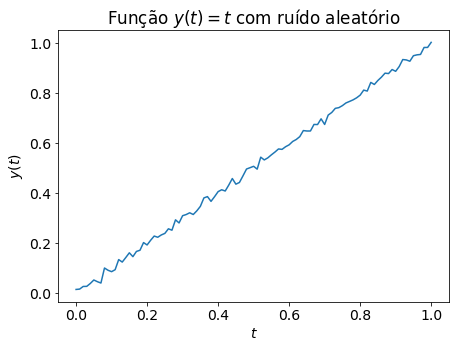

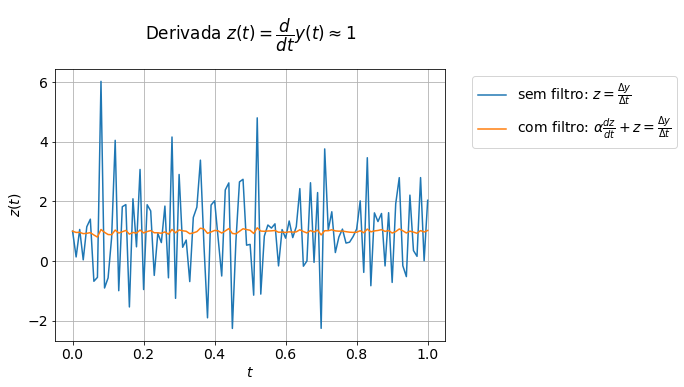

In [4]:
n = 101
tf = 1
Δt = tf/(n-1)
t = np.linspace(0,tf,n)
y = t + 0.01*np.random.randn(n)
plt.plot(t,y)
plt.ylabel(r"$y(t)$")
plt.xlabel(r"$t$")
plt.title(r"Função $y(t) = t$ com ruído aleatório")

z = np.ones(n)
for i in range(1,n):
    z[i] = (y[i]-y[i-1])/Δt
    
plt.figure() 
plt.plot(t,z, label = r"sem filtro: $z = \frac{\Delta y}{\Delta t}$")

α = 0.2
dy = np.ones(n)
for i in range(1,n):
    dy[i] = odeint(lambda y,t: (-y + z[i])/α, dy[i-1], t)[1] # consertar isso aqui!
    
plt.plot(t,dy, label = r"com filtro: $\alpha \frac{dz}{dt} + z = \frac{\Delta y}{\Delta t}$")
plt.title(r"Derivada $z(t) = \dfrac{d}{dt}y(t) \approx 1$"+"\n")
plt.ylabel(r"$z(t)$")
plt.xlabel(r"$t$")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()

### PID dependente, independente ou com interação

O controle PID também pode variar quanto aos parâmetros utilizados. Há três formas mais comuns, que ainda podem ser combinadas com as versões sem chute derivativo e com filtro, o que é recomendado. As funções de transferência (com filtro) são as que se seguem:

* dependente ideal: os termos integral e derivativo dependem do termo proporcional $K_c$.
\begin{equation}
    C(s) = K_c \left( 1 + \frac{1}{\tau_Is} + \frac{\tau_D s}{\alpha \tau_D s + 1} \right)
\end{equation}

* dependente real/em série/com interação: troca a ação derivativa por uma dinâmica de avanço, o que é mais fácil de implementar num dispositivo analógico.
\begin{equation}
    C(s) = K_c^\prime \left( 1 + \frac{1}{\tau_I^\prime s}\right)\left( \frac{\tau_D^\prime s + 1}{\alpha \tau_D s + 1} \right)
\end{equation}

* independente/em paralelo: os termos proporcional, integral e derivativo são todos independentes.
\begin{equation}
    C(s) = K_P + \frac{K_I}{s} + \frac{K_D s}{\alpha K_D s + 1}
\end{equation}


Todas essas formas são equivalentes e é possível converter os parâmetros entre uma forma e outra. Da dependente real para a ideal, por exemplo,

\begin{gather*}
    K_c = K_c^\prime\left(1+\frac{\tau_D^\prime}{\tau_I^\prime}\right) \\
    \tau_I = \tau_I^\prime + \tau_D^\prime \\
    \tau_D = \frac{\tau_D^\prime \tau_I^\prime}{\tau_I^\prime + \tau_D^\prime}
\end{gather*}

É importante ter consciência dessas diferentes formulações do PID, entretanto, porque diferentes fabricantes podem usar diferentes formas e, por isso, é preciso ter cuidado ao definir os parâmetros de um controlador. Nas próximas aulas estudaremos como projetar um controlador escolhendo os melhores valores para os seus parâmetros. Os métodos que estudaremos se aplicam ao PID ideal, o que significa que seria necessário fazer alguma conversão para usá-los para ajustar o parâmetro de um PID de outro tipo.

### Efeito do termo derivativo

Voltando ao exemplo do refrigerador, vejamos como se comparam as respostas a uma perturbação (problema regulador) quando o controlador é PI e quando é PID.

In [5]:
def principal(Kc,τi,τd):
    # definição do tempo
    tf = 36
    n = 201

    # set-point
    Ta = 40
    Tsp = 6
    x = np.ones(n)*Tsp
    
     # estímulo
    d = Ta - Tsp
    sp = 0

    t,z = geladeira_PID(tf, Tsp, Tsp, d, sp, Kc, τi, n = n)
    t,y = geladeira_PID(tf, Tsp, Tsp, d, sp, Kc, τi, τd, n = n) 
    plt.rcParams["figure.figsize"]=[7,5]
    plt.rcParams.update({'font.size': 14})
    plt.plot(t,z, label = "controle PI")
    plt.plot(t,y, label = "controle PID" )
    #plt.text(9,21,"(bias = 0)",backgroundcolor="white")
    plt.plot(t,x, 'r--')
    plt.xlabel("Tempo (h)")
    plt.ylabel("Temperatura (°C)\n")
    plt.grid()
    plt.legend(loc = 'right')

Kc_widget = widgets.FloatSlider(min=0, max=10, step=2.5, value=5, description = r'$K_c$')
τi_widget = widgets.FloatSlider(min=0.5, max=12, step=1.5, value=6, description = r'$\tau_I$')
τd_widget = widgets.FloatSlider(min=0.5, max=3, step=0.5, value=1.5, description = r'$\tau_D$')
w = widgets.interact(principal, Kc = Kc_widget, τi = τi_widget, τd = τd_widget)
w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatSlider(value=5.0, description='$K_c$', max=10.0, step=2.5), FloatSlider(value=6.0, …

<function __main__.principal(Kc, τi, τd)>

A ação derivativa pode melhorar o desempenho do controlador, reduzindo o pico da variável controlada e fazendo-a voltar ao valor desejado mais rapidamente.

Por outro lado uma má escolha de parâmetros ($\tau_I$ pequeno, $\tau_D$ grande) também pode piorar o desempenho do sistema de controle em certos sentidos, fazendo com que a resposta leve mais tempo para se estabilizar.

A simulação acima pode ser escrita no Xcos seguindo-se o esquema da figura abaixo. Observe que no Xcos os parâmetros do controlador são os ganhos $K_P = K_c$, $K_I = \frac{K_c}{\tau_I}$ e $K_D = K_c\tau_D$.

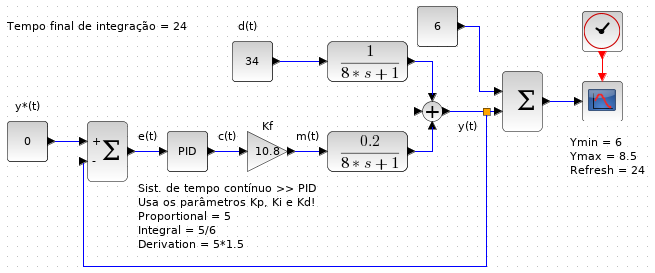

## Projeto de controladores: P, PI ou PID?

Um controlador PID com parâmetros bem ajustados geralmente fornece as melhores resposta em malha fechada. Por outro lado, trabalhar com controladores desse tipo é uma tarefa relativamente complexa porque há três parâmetros para ajustar em vez de dois no PI e um no P. Além disso, a grande quantidade de variações no algoritmo PID pode causar confusão.

O controlador P é o mais simples de projetar, mas precisa ser acompanhado constantemente por um operador humano para evitar erros permanentes, o que é indesejável. O meio termo entre relativa simplicidade e bom desempenho é o controlador PI, que não por acaso é o controlador mais usado na indústria.

Via de regra, a escolha do melhor controlador para um processo depende das respostas às seguintes perguntas:

* **Algum erro permanente é tolerável?** Se sim, escolhe-se o controlador P.
* **Há ruído excessivo na medida?** Um pouco de ruído não impede o uso do controlador PID com filtro derivativo, mas se o ruído for excessivo, não teremos outra escolha senão usar o controlador PI.
* **O processo tem dinâmica muito lenta?** Quando o processo tem resposta dinâmica muito lenta (por exemplo, trocas de calor ou fermentação), é interessante investir em um controlador com resposta mais rápida. Nesse caso é preferível usar o controlador PID. Se o sistema já tem uma dinâmica rápida, o controlador PI geralmente é satisfatório.

## Bibliografia

* C.A. Kluever (2018). Sistemas Dinâmicos: Modelagem, Simulação e Controle. LTC. Capítulo 10.
* B.W. Bequette. (2003). Process Control: Modeling, Design and Simulation. PHI Learning. Capítulo 5.
* C. Garcia (2017). Controle de Processos Industriais: Estratégias Convencionais. Volume 1, Blucher. Capítulo 7.
* C.A. Smith, A. Corripio (2008). Princípios e Prática do Controle Automático de Processo. 3ª ed. LTC. Capítulos 5 e 6.
* W.Y. Svrcek, D.P.Mahoney, B.R. Young (2014). A Real Time Approach to Process Control. 3ª ed. Wiley. Capítulo 4.
* M. King (2016). Process Control, a Practical Approach. 2ª ed. Wiley. Capítulo 3.
* J.C. Kantor (2019). [CBE 30338 Chemical Process Control](http://jckantor.github.io/CBE30338/). Capítulo 4.
* D. Cooper et al. (2019). [Practical Process Control](https://controlguru.com/table-of-contents/). Control Guru. Capítulos 8, 9 e 10.